In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing libraries for portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [3]:
from scipy.optimize import minimize

In [4]:
from distfit import distfit

In [5]:
!python -V

Python 3.10.13


In [6]:
%pip list

Package                      Version        Editable project location
---------------------------- -------------- ---------------------------
absl-py                      2.1.0
accelerate                   0.26.0
aiohappyeyeballs             2.4.3
aiohttp                      3.11.8
aiosignal                    1.3.1
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-timeout                5.0.1
attrs                        24.2.0
beautifulsoup4               4.11.1
blis                         0.7.11
boto3                        1.35.71
botocore                     1.35.71
cachetools                   5.5.0
catalogue                    2.0.10
certifi                      2024.8.30
cffi                         1.17.1
charset-normalizer           3.4.0
clarabel                     0.9.0
click                        7.1.2
colorama                     0.4.6
coloredlogs                  15.0.1
colourmap                    1.1.19
c

### investments tickers

In [7]:
symbol_type = "ETF"

In [8]:
yf_market_info  = pd.read_csv('../data/market_info.csv')

In [9]:
ticker_info_df = yf_market_info[yf_market_info.symbol_type==symbol_type].reset_index()
ticker_list = list(ticker_info_df.symbol)
ticker_name = list(ticker_info_df.symbol_name)
ticker_currency = list(ticker_info_df.unit)
ticker_dict = dict(map(lambda i,j : (i,j) , ticker_list,ticker_name))
ticker_currency_dict = dict(map(lambda i,j : (i,j) , ticker_list,ticker_currency))

In [10]:
ticker_name

['SP500',
 'FTSEALL',
 'NIKKEI225',
 'STOXX600',
 'ASIA',
 'INDIA',
 'BRAZIL',
 'US dollar ex rate',
 'UKGILTS',
 'ASIA1']

In [11]:
ticker_name_minus_ex_rate = [item for item in ticker_name if item != 'US dollar ex rate']

In [12]:
ticker_name_minus_ex_rate

['SP500',
 'FTSEALL',
 'NIKKEI225',
 'STOXX600',
 'ASIA',
 'INDIA',
 'BRAZIL',
 'UKGILTS',
 'ASIA1']

In [13]:
ticker_dict

{'SPXP.L': 'SP500',
 'FTAL.L': 'FTSEALL',
 'CNKY.L': 'NIKKEI225',
 'S600.L': 'STOXX600',
 'HMAF.L': 'ASIA',
 'FRIN.L': 'INDIA',
 'FVUB.L': 'BRAZIL',
 'USDGBP=X': 'US dollar ex rate',
 '0P0001HIYI.L': 'UKGILTS',
 'HEMA.L': 'ASIA1'}

In [14]:
ticker_currency_dict

{'SPXP.L': 'GBP',
 'FTAL.L': 'GBP',
 'CNKY.L': 'GBP',
 'S600.L': 'GBP',
 'HMAF.L': 'GBP',
 'FRIN.L': 'GBP',
 'FVUB.L': 'GBP',
 'USDGBP=X': 'USD',
 '0P0001HIYI.L': 'GBP',
 'HEMA.L': 'USD'}

In [15]:
ticker_symbols  = " ".join(ticker_list)
ticker_symbols

'SPXP.L FTAL.L CNKY.L S600.L HMAF.L FRIN.L FVUB.L USDGBP=X 0P0001HIYI.L HEMA.L'

In [16]:
#ticker_symbols = ticker_symbols + " EURGBP=X"

In [17]:
data = yf.download(ticker_symbols, period='1y')
data.head(5)

[*********************100%***********************]  10 of 10 completed


Price             Close                                                    \
Ticker     0P0001HIYI.L   CNKY.L     FRIN.L     FTAL.L     FVUB.L  HEMA.L   
Date                                                                        
2024-01-22     0.691347  19376.0  31.912500  60.610001  20.785000  10.050   
2024-01-23     0.686218  19237.0  31.147499  60.575001  20.915001  10.105   
2024-01-24     0.681574  19220.0  31.502501  60.930000  21.209999  10.299   
2024-01-25     0.679155  19141.0  31.517500  60.924999  21.270000  10.260   
2024-01-26     0.681380  19041.0  31.597500  61.724998  21.325001  10.287   

Price                                            ...       Volume           \
Ticker         HMAF.L  S600.L   SPXP.L USDGBP=X  ... 0P0001HIYI.L   CNKY.L   
Date                                             ...                         
2024-01-22  32.314999  9602.0  74346.5  0.78741  ...          0.0  18244.0   
2024-01-23  32.939999  9566.0  74488.5  0.78697  ...          0.0    563.0   
2024-01-24  33.455002  9678.0  74769.5  0.78790  ...          0.0   3701.0   
2024-01-25  33.430000  9676.5  75027.5  0.78624  ...          0.0    204.0   
2024-01-26  33.419998  9801.0  75044.0  0.78689  ...          0.0   2445.0   

Price                                                                          
Ticker       FRIN.L   FTAL.L  FVUB.L   HEMA.L  HMAF.L S600.L  SPXP.L USDGBP=X  
Date                                                                           
2024-01-22  17046.0   5082.0  1355.0  19392.0   111.0  317.0   979.0        0  
2024-01-23  27512.0   5069.0  2820.0   5300.0  7922.0  570.0  1662.0        0  
2024-01-24  11296.0  15558.0    94.0   5605.0  4071.0   41.0   818.0        0  
2024-01-25  19954.0   5899.0   127.0      0.0  2113.0  951.0  1011.0        0  
2024-01-26  13765.0   2642.0   761.0    300.0  1540.0    0.0   897.0        0  

[5 rows x 50 columns]

In [18]:
# forward fill exchange rate
#data['USDGBP=X'] = data['USDGBP=X'].ffill()

### returns

In [60]:
# some funds have just 5 year history - so ok for upto 2 years
yf_period = "5y" # ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
yf_interval = "1d"

In [61]:
#  1.  Create dataframe yf_price with yf.download
yf_df = yf.download(
        tickers = ticker_symbols,       # tickers list or string as well
        period = yf_period,      # optional, default is '1mo'
        interval = yf_interval,  # fetch data by intervaal
        group_by = 'ticker',     # group by ticker
        auto_adjust = True,      # adjust all OHLC (open-high-low-close)
        prepost = True,          # download market hours data
        threads = True,          # threads for mass downloading
        proxy = None)            # proxy

#  2.  Select 'Close' (price at market close) column only
yf_df = yf_df.iloc[:, yf_df.columns.get_level_values(1)=='Close']

#  3.  Remove the dataframe multi-index
yf_df.columns = yf_df.columns.droplevel(1)  # multi-index

[*********************100%***********************]  10 of 10 completed


### forward fill exchange rate

In [62]:
# forward fill exchange rate
yf_df['USDGBP=X'] = yf_df['USDGBP=X'].ffill()

### convert USD ETF's to GBP

In [63]:
for i in ticker_currency_dict:
    if ticker_currency_dict[i]== 'USD':
        # convert column
        yf_df[i] = yf_df[i].multiply(yf_df["USDGBP=X"], axis="index")

In [64]:
yf_name_df = yf_df.rename(columns=ticker_dict)

In [65]:
yf_name_df.isnull().sum()

Ticker
US dollar ex rate      1
ASIA                  43
ASIA1                658
FTSEALL               43
UKGILTS               43
STOXX600              43
BRAZIL                43
NIKKEI225             43
SP500                 43
INDIA                 43
dtype: int64

In [66]:
yf_name_df.dropna(inplace=True)

In [67]:
yf_name_df.shape

(648, 10)

In [68]:
yf_name_df.drop(columns="US dollar ex rate", axis=0, inplace=True)

In [69]:
yf_name_df

Ticker,ASIA,ASIA1,FTSEALL,UKGILTS,STOXX600,BRAZIL,NIKKEI225,SP500,INDIA
Date,,,,,,,,,
2022-06-28,39.090000,6.841847,56.560001,0.856201,8227.5,16.297001,15826.5,60341.0,24.872499
2022-06-29,38.740002,6.831662,56.435001,0.858078,8181.0,16.224001,15737.0,59756.0,24.969999
2022-06-30,38.334999,6.814827,55.264999,0.863802,8029.5,16.062000,15553.5,59184.0,24.860001
2022-07-01,38.419998,6.731644,55.130001,0.884637,8062.0,15.864000,15623.0,59669.5,25.082500
2022-07-04,38.209999,6.801318,55.599998,0.889424,8083.5,15.969000,15555.0,59785.0,25.017500
...,...,...,...,...,...,...,...,...,...
2025-01-14,39.924999,7.457202,67.980003,0.650800,10436.0,17.035000,20118.0,94251.0,34.599998
2025-01-15,40.215000,7.569309,68.949997,0.657400,10554.0,17.212999,20274.5,95526.5,34.814999
2025-01-16,40.555000,7.565731,69.769997,0.664900,10662.0,17.301001,20342.0,95991.0,34.580002


### returns

In [70]:
SP500_fee = yf_market_info[(yf_market_info.symbol_name=='SP500') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
SP500_fee

6    0.000001
Name: fidelity annual fee (%), dtype: float64

In [71]:
NIKKEI225_fee = yf_market_info[(yf_market_info.symbol_name=='NIKKEI225') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
NIKKEI225_fee

18    0.000019
Name: fidelity annual fee (%), dtype: float64

In [72]:
BRAZIL_fee = yf_market_info[(yf_market_info.symbol_name=='BRAZIL') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
BRAZIL_fee

52    0.000008
Name: fidelity annual fee (%), dtype: float64

In [73]:
ASIA_fee = yf_market_info[(yf_market_info.symbol_name=='ASIA') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
ASIA_fee

50    0.000018
Name: fidelity annual fee (%), dtype: float64

In [74]:
ASIA1_fee = yf_market_info[(yf_market_info.symbol_name=='ASIA1') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
ASIA1_fee

55    0.000006
Name: fidelity annual fee (%), dtype: float64

In [75]:
FTSEALL_fee = yf_market_info[(yf_market_info.symbol_name=='FTSEALL') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
FTSEALL_fee

15    0.000002
Name: fidelity annual fee (%), dtype: float64

In [76]:
STOXX600_fee = yf_market_info[(yf_market_info.symbol_name=='STOXX600') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
STOXX600_fee

20    0.000003
Name: fidelity annual fee (%), dtype: float64

In [77]:
UKGILTS_fee = yf_market_info[(yf_market_info.symbol_name=='UKGILTS') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
UKGILTS_fee

54    0.000006
Name: fidelity annual fee (%), dtype: float64

In [78]:
INDIA_fee = yf_market_info[(yf_market_info.symbol_name=='INDIA') & (yf_market_info.symbol_type=='ETF')]['fidelity annual fee (%)']/(100 * 252)
INDIA_fee

51    0.000008
Name: fidelity annual fee (%), dtype: float64

In [79]:
#Create a new columns Return in the dataset for each company's
yf_name_df['R_SP500'] = yf_name_df[['SP500']].pct_change(1) - 0.000001
yf_name_df['R_NIKKEI225'] = yf_name_df[['NIKKEI225']].pct_change(1) -0.000019
yf_name_df['R_BRAZIL'] = yf_name_df[['BRAZIL']].pct_change(1) - 0.000008
yf_name_df['R_ASIA'] = yf_name_df[['ASIA']].pct_change(1) - 0.000018
yf_name_df['R_ASIA1'] = yf_name_df[['ASIA1']].pct_change(1) - 0.000006
yf_name_df['R_FTSEALL'] = yf_name_df[['FTSEALL']].pct_change(1) - 0.000002
yf_name_df['R_STOXX600'] = yf_name_df[['STOXX600']].pct_change(1) - 0.000003
yf_name_df['R_UKGILTS'] = yf_name_df[['UKGILTS']].pct_change(1) - 0.000006
yf_name_df['R_INDIA'] = yf_name_df[['INDIA']].pct_change(1) - 0.000008

In [80]:
returns  = yf_name_df[['R_SP500','R_NIKKEI225','R_BRAZIL','R_ASIA','R_ASIA1', 'R_FTSEALL','R_STOXX600','R_UKGILTS','R_INDIA' ]]

### sharpe ratio

In [81]:
# The Sharpe ratio gives the excess return of a stock (or a portfolio) per unit of risk.

In [82]:
# set the number of days in this sample to be the number of rows
n_days = returns.shape[0]
def sharpe_ratio (serie, rf = 0.045):
    ''''
    serie : Series of daily returns of the stock or portfolio
    rf: annual return on a risk-free investment (default rf=0.045)
    '''''
    # Mean Annualized Return
    rp = serie.mean()*n_days
    # Annual volatility
    volatility = serie.std()*np.sqrt(n_days)
    # Sharpe ratio
    sharpe = (rp - rf) / volatility
    return sharpe

In [83]:
for col in returns.columns:
    print("Sharpe ratio:", col,"=", round(sharpe_ratio(yf_name_df[col]),2 ))

Sharpe ratio: R_SP500 = 2.16
Sharpe ratio: R_NIKKEI225 = 0.93
Sharpe ratio: R_BRAZIL = 0.25
Sharpe ratio: R_ASIA = 0.14
Sharpe ratio: R_ASIA1 = 0.4
Sharpe ratio: R_FTSEALL = 1.06
Sharpe ratio: R_STOXX600 = 1.22
Sharpe ratio: R_UKGILTS = -0.68
Sharpe ratio: R_INDIA = 1.38


### portfolio optimisation

In [84]:
# Portfolio Simulation
portfolio        = 2673  # generation of a portfolio
n_assets         = returns.shape[1]
weights          = np.random.dirichlet(np.full(n_assets,0.05),portfolio)
mean_returns     = returns.mean()
sigma            = returns.cov()
expected_returns = np.zeros(portfolio)
expected_vol     = np.zeros(portfolio)
sharpe_ratio     = np.zeros(portfolio)
rf_rate          = 0.0                          # risk free rate

for i in range(portfolio):
    w                   = weights[i,:]
    expected_returns[i] = np.sum(mean_returns @ w)*n_days
    expected_vol[i]     = np.sqrt(np.dot(w.T,sigma @ w))*np.sqrt(n_days)
    sharpe_ratio[i]     = (expected_returns[i]-rf_rate)/expected_vol[i]

In [85]:
def portfolio_volatility(weight):
    return np.sqrt(np.dot(weight.T,
                          np.dot(sigma,weight)))*np.sqrt(n_days)

def portfolio_return(weight):

    return np.sum(mean_returns*weight)*n_days

def portfolio_performance(weight):
    return_p = portfolio_return(weight)
    vol_p    = portfolio_volatility(weight)
    return return_p, vol_p

In [86]:
def negativeSR(weight):
    return_p, vol_p = portfolio_performance(weight)
    rf_rate         = 0.045
    return -(return_p - rf_rate)/vol_p

def max_sharpe_ratio():

    def sum_one(weight):
        w= weight
        return np.sum(weight)-1

    n_assets           = returns.shape[1]
    weight_constraints = ({'type':'eq','fun': sum_one})
    w0                 = np.random.dirichlet(np.full(n_assets,0.05)).tolist()    # w0 is an initila guess

    return minimize(negativeSR,w0,method='SLSQP',
                          bounds  =((0,1),)*n_assets,
                      constraints = weight_constraints)

In [87]:
def min_vol():

    n_assets           = returns.shape[1]
    weight_constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1})
    w0                 = np.random.dirichlet(np.full(n_assets,0.05)).tolist()
    bounds             = ((0,1),)*n_assets

    return minimize(portfolio_volatility,w0,method='SLSQP',
                   bounds      = bounds,
                   constraints = weight_constraints)

In [88]:
def efficient_portfolio_target(target):

    constraints = ({'type':'eq','fun': lambda x: portfolio_return(x)- target},
                  {'type' :'eq','fun': lambda x: np.sum(x)-1})
    w0          = np.random.dirichlet(np.full(n_assets,0.05)).tolist()
    bounds      = ((0,1),)*n_assets

    return minimize(portfolio_volatility,w0, method = 'SLSQP',
                    bounds      = bounds,
                    constraints = constraints)

In [89]:
def efficient_frontier(return_range):
    return [efficient_portfolio_target(ret) for ret in return_range]

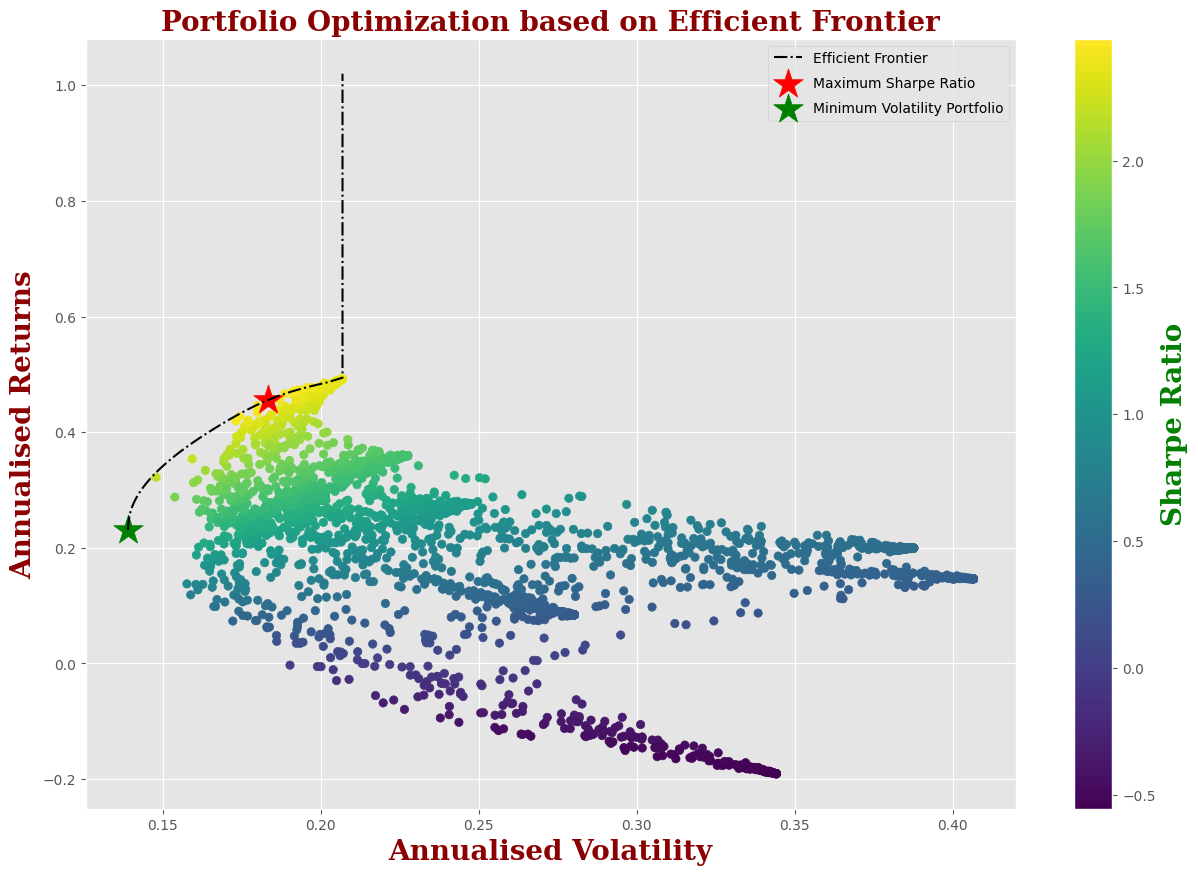

In [90]:
sharpe_maximum      = max_sharpe_ratio()
return_p,vol_p      = portfolio_performance(sharpe_maximum['x'])
min_volatility      = min_vol()
return_min,vol_min  = portfolio_performance(min_volatility['x'])


plt.figure(figsize =(15,10))
plt.style.use('ggplot')
plt.scatter(expected_vol,expected_returns, c = sharpe_ratio)
# plt.colorbar.sel(label = 'Sharpe Ratio',size=20)
plt.colorbar().set_label('Sharpe Ratio', size= 20, color = 'g', family='serif',weight='bold')
target               = np.linspace(return_min,1.02,100)
efficient_portfolios = efficient_frontier(target)
plt.plot([i.fun for i in efficient_portfolios], target, linestyle ='dashdot', color ='black',
         label='Efficient Frontier')
plt.scatter(vol_p,return_p, c = 'r', marker='*', s = 500, label = 'Maximum Sharpe Ratio')
plt.scatter(vol_min,return_min, c = 'g',  marker ='*', s = 500, label='Minimum Volatility Portfolio')

font1 = {'family':'serif','color':'darkred','size':20,'weight':'bold'}
font2 = {'family':'serif','color':'darkred','size':20,'weight':'bold'}
plt.title('Portfolio Optimization based on Efficient Frontier',fontdict=font1)
plt.xlabel('Annualised Volatility',fontdict=font2)
plt.ylabel('Annualised Returns',fontdict=font2)
plt.legend(labelspacing=0.8)

### random portfolio simulation

In [91]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):# portfolio performance, calculate the annualised return, sharpe ratio
    portfolio_return = np.sum(mean_returns*weights)*252 #252 working days at the stock exchange
    portfolio_std = np.sqrt(np.dot(weights.T,np.dot(cov,weights)))*np.sqrt(252) # np.dot multiplication of matrices
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf): # random simulation
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights=np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
    return results_df

In [92]:
yf_name_df

Ticker,ASIA,ASIA1,FTSEALL,UKGILTS,STOXX600,BRAZIL,NIKKEI225,SP500,INDIA,R_SP500,R_NIKKEI225,R_BRAZIL,R_ASIA,R_ASIA1,R_FTSEALL,R_STOXX600,R_UKGILTS,R_INDIA
Date,,,,,,,,,,,,,,,,,,
2022-06-28,39.090000,6.841847,56.560001,0.856201,8227.5,16.297001,15826.5,60341.0,24.872499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-29,38.740002,6.831662,56.435001,0.858078,8181.0,16.224001,15737.0,59756.0,24.969999,-0.009696,-0.005674,-0.004487,-0.008972,-0.001495,-0.002212,-0.005655,0.002186,0.003912
2022-06-30,38.334999,6.814827,55.264999,0.863802,8029.5,16.062000,15553.5,59184.0,24.860001,-0.009573,-0.011679,-0.009993,-0.010472,-0.002470,-0.020734,-0.018522,0.006666,-0.004413
2022-07-01,38.419998,6.731644,55.130001,0.884637,8062.0,15.864000,15623.0,59669.5,25.082500,0.008202,0.004449,-0.012335,0.002199,-0.012212,-0.002445,0.004045,0.024114,0.008942
2022-07-04,38.209999,6.801318,55.599998,0.889424,8083.5,15.969000,15555.0,59785.0,25.017500,0.001935,-0.004372,0.006611,-0.005484,0.010344,0.008523,0.002664,0.005405,-0.002599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-14,39.924999,7.457202,67.980003,0.650800,10436.0,17.035000,20118.0,94251.0,34.599998,0.003689,-0.001458,-0.001415,0.011510,0.007732,-0.002643,0.004134,-0.000620,0.007123
2025-01-15,40.215000,7.569309,68.949997,0.657400,10554.0,17.212999,20274.5,95526.5,34.814999,0.013532,0.007760,0.010441,0.007246,0.015027,0.014267,0.011304,0.010135,0.006206
2025-01-16,40.555000,7.565731,69.769997,0.664900,10662.0,17.301001,20342.0,95991.0,34.580002,0.004862,0.003310,0.005104,0.008437,-0.000479,0.011891,0.010230,0.011403,-0.006758


In [93]:
ticker_name_minus_ex_rate

['SP500',
 'FTSEALL',
 'NIKKEI225',
 'STOXX600',
 'ASIA',
 'INDIA',
 'BRAZIL',
 'UKGILTS',
 'ASIA1']

In [94]:
tickers = []
for i in yf_name_df[ticker_name_minus_ex_rate].columns:
    tickers.append(i)

In [95]:
mean_returns = yf_name_df[ticker_name_minus_ex_rate].pct_change().mean()
cov = yf_name_df[ticker_name_minus_ex_rate].pct_change().cov()
num_portfolios = 10000
rf = 0.045
results_frame =simulate_random_portfolios(num_portfolios, mean_returns,cov, rf) #random selection/creation of the portfolio

In [96]:
results_frame.sum(axis=1)-results_frame["ret"]-results_frame["stdev"]-results_frame["sharpe"];

In [97]:
results_frame

,ret,stdev,sharpe,SP500,FTSEALL,NIKKEI225,STOXX600,ASIA,INDIA,BRAZIL,UKGILTS,ASIA1
0,0.072407,0.097763,0.280341,0.009257,0.111702,0.180849,0.012348,0.119537,0.204327,0.102107,0.141376,0.118497
1,0.074908,0.107368,0.278555,0.050797,0.146549,0.064241,0.188899,0.212608,0.031068,0.048191,0.083788,0.173859
2,0.069247,0.091950,0.263693,0.085480,0.192050,0.084831,0.187165,0.039272,0.085622,0.045129,0.225844,0.054607
3,0.079718,0.097659,0.355502,0.162479,0.158181,0.088079,0.067707,0.126656,0.050795,0.125737,0.134928,0.085438
4,0.060651,0.097372,0.160734,0.040729,0.238444,0.073787,0.021483,0.257813,0.098358,0.031310,0.160206,0.077868
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.083711,0.101541,0.381241,0.117153,0.093596,0.098296,0.168632,0.044950,0.063136,0.158541,0.117608,0.138088
9996,0.116920,0.102080,0.704550,0.217625,0.034886,0.177304,0.343712,0.002789,0.048920,0.037031,0.046855,0.090877
9997,0.060102,0.095797,0.157646,0.103662,0.146230,0.044484,0.012112,0.137206,0.108689,0.122050,0.218817,0.106751
9998,0.075013,0.102540,0.292699,0.147994,0.173918,0.089375,0.006124,0.017708,0.079469,0.221345,0.172055,0.092012


In [108]:
high_ret = results_frame.ret > 0.10
low_stdev = results_frame.stdev < 0.115
results_frame[high_ret & low_stdev].mean()

ret          0.106417
stdev        0.103809
sharpe       0.593233
SP500        0.173110
FTSEALL      0.112957
NIKKEI225    0.127418
STOXX600     0.125977
ASIA         0.082642
INDIA        0.141289
BRAZIL       0.094421
UKGILTS      0.038257
ASIA1        0.103929
dtype: float64

In [105]:
10 + 20 + 15 + 15 + 10 +15+5+ 0+10

100

In [106]:
10 + 25 + 10 + 15 +10 +15 + 5 + 0 + 5

95

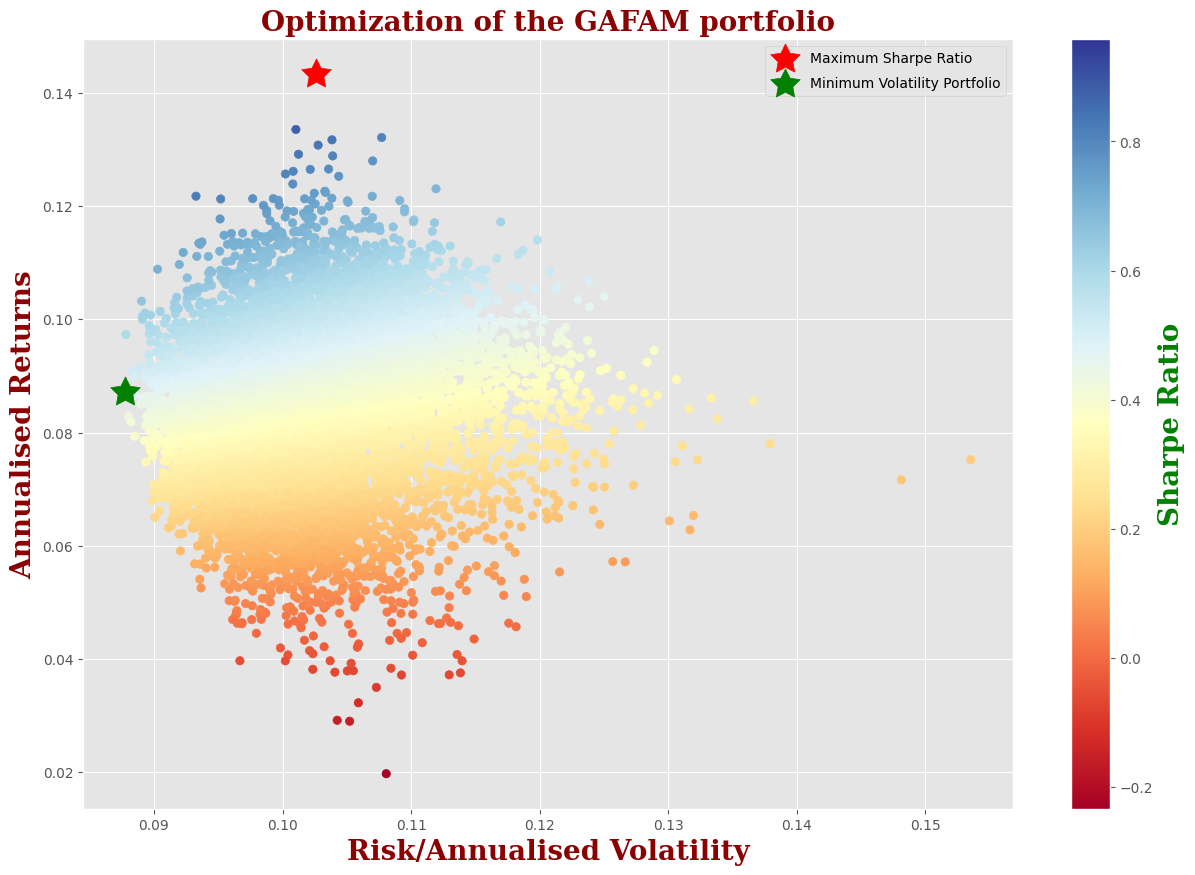

In [100]:
#Locate position of portfolio with highest Sharpe Ratio
max_sharpe_port=results_frame.iloc[results_frame["sharpe"].idxmax()] # max sharp ratio rouge
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame["stdev"].idxmin()] # min volatility = min variance portfolio vert
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10)) # Number of rows/colums of the subplot grid
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu') #Colormaps in Matplotlib
plt.title('Optimization of the GAFAM portfolio',fontdict=font1)
plt.xlabel('Risk/Annualised Volatility',fontdict=font2)
plt.ylabel('Annualised Returns',fontdict=font2)
#plt.colorbar () # match the colorbar
plt.colorbar().set_label('Sharpe Ratio', size= 20, color = 'g', family='serif',weight='bold')
target               = np.linspace(return_min,1.02,100)
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500, label = 'Maximum Sharpe Ratio')
#plot green star to highlight position of minimum vartance portfolio
plt.scatter(min_vol_port[1] ,min_vol_port[0],marker=(5,1,0),color='g', s=500, label='Minimum Volatility Portfolio')
plt.legend(labelspacing=0.8)
plt.savefig('Portfolio_Optimization_Efficient_Frontier.pdf')
plt.show()

In [101]:
max_sharpe_port.to_frame().T # portfolio with the highest Sharpe ratio. it is negative when the investment return is Lower than

,ret,stdev,sharpe,SP500,FTSEALL,NIKKEI225,STOXX600,ASIA,INDIA,BRAZIL,UKGILTS,ASIA1
3159,0.143399,0.102583,0.95921,0.337247,0.086634,0.111234,0.015043,0.003446,0.354023,0.032452,0.002831,0.057091


In [102]:
min_vol_port.to_frame().T #portfolio with the Lowest variance portfolio

,ret,stdev,sharpe,SP500,FTSEALL,NIKKEI225,STOXX600,ASIA,INDIA,BRAZIL,UKGILTS,ASIA1
1584,0.087183,0.087771,0.480604,0.164007,0.188475,0.010535,0.011589,0.074576,0.268414,0.00262,0.180655,0.099129


### statistics

In [ ]:
daily_returns_df = yf_name_df.pct_change()

In [ ]:
daily_returns_df.mean(skipna=True)

In [ ]:
daily_returns_df.std(skipna=True)

In [ ]:
daily_returns_df.kurtosis()

In [ ]:
daily_returns_df.skew()

In [ ]:
# Pairplots
sns.pairplot(daily_returns_df, kind = 'reg')
plt.show()

In [ ]:
yf_name_df

In [ ]:
from scipy import stats
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(18,16))

    axes[0][0].plot(yf_name_df['FTSEALL'], color='blue')
    axes[0][0].set_title('Daily Returns FTSE all-share')

    sns.distplot(yf_name_df['FTSEALL'], norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Density of FTSE all-share')

    
    axes[1][0].plot(yf_name_df['STOXX600'], color='green')
    axes[1][0].set_title('Daily Returns of STOXX Europe 600')

    sns.distplot(yf_name_df['STOXX600'], norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Density of STOXX Europe 600')

    
    axes[2][0].plot(yf_name_df['NIKKEI225'], color='brown')
    axes[2][0].set_title('Daily Returns NIKKEI 225')

    sns.distplot(yf_name_df['NIKKEI225'], norm_hist=True, fit=stats.norm, color='brown',
                bins=50, ax=axes[2][1])
    axes[2][1].set_title('Density of NIKKEI 225')

    
    axes[3][0].plot(yf_name_df['SP500'], color='red')
    axes[3][0].set_title('Daily Returns S&P 500')

    sns.distplot(yf_name_df['SP500'], norm_hist=True, fit=stats.norm, color='red',
                bins=50, ax=axes[3][1])
    axes[3][1].set_title('Density of S&P 500')

    axes[4][0].plot(yf_name_df['ASIA'], color='red')
    axes[4][0].set_title('Daily Returns Asia (ex Japan)')

    sns.distplot(yf_name_df['ASIA'], norm_hist=True, fit=stats.norm, color='red',
                bins=50, ax=axes[4][1])
    axes[4][1].set_title('Density of Asia (ex Japan)')

    
    axes[5][0].plot(yf_name_df['UKGILTS'], color='red')
    axes[5][0].set_title('Daily Returns UK Gilts')

    sns.distplot(yf_name_df['UKGILTS'], norm_hist=True, fit=stats.norm, color='red',
                bins=50, ax=axes[5][1])
    axes[5][1].set_title('Density of UK Gilts')

    
    axes[6][0].plot(yf_name_df['INDIA'], color='yellow')
    axes[6][0].set_title('Daily Returns India')

    sns.distplot(yf_name_df['INDIA'], norm_hist=True, fit=stats.norm, color='yellow',
                bins=50, ax=axes[6][1])
    axes[6][1].set_title('Density of India')

    axes[7][0].plot(yf_name_df['BRAZIL'], color='blue')
    axes[7][0].set_title('Daily Returns Brazil')

    sns.distplot(yf_name_df['BRAZIL'], norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[7][1])
    axes[7][1].set_title('Density of Brazil')

    axes[8][0].plot(yf_name_df['ASIA1'], color='blue')
    axes[8][0].set_title('Daily Returns Asia 1')

    sns.distplot(yf_name_df['ASIA1'], norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[8][1])
    axes[8][1].set_title('Density of Asia 1') 
    
    plt.tight_layout()
    plt.show()

### check for dividends - check all ETFs reinvest dividends i.e. accumulate (acc)

In [ ]:
ticker_list

In [ ]:
yf_dividend = pd.DataFrame()   # initialize dataframe

for i in ticker_list:
    x = pd.DataFrame(yf.Ticker(i).dividends)
    x = x.rename(columns={"Dividends":i})
    yf_dividend = pd.concat([yf_dividend,x], axis=1)
    if len(x) > 0:
        print('{:>8}\t- dividends'.format(i))
    else:
        print('{:>8}\t- no dividends'.format(i))             

In [ ]:
yf_dividend

### check currencies

In [ ]:
ticker_list

In [ ]:
tickers = yf.Tickers(ticker_symbols)
for i in ticker_list:
    print(f"{ticker_dict[i]} : {tickers.tickers[i].info['currency']}")

In [ ]:
tickers.tickers['FRIN.L'].info # india

In [ ]:
ticker_info_df

### correlation

### fit curves

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(daily_returns_df,bins=100)
#plt.ylim(0,1500)
plt.xlim(-0.05,0.05)
plt.xlabel('daily_return %')
plt.ylabel('frequency')
plt.title('daily % returns 10yrs')

# Initialize distfit - ftse
dist = distfit()

# Determine best-fitting probability distribution for data
dist.fit_transform(daily_returns_df['FTAL.L'].dropna())

print(dist.summary)

# Plot results
dist.plot()
plt.show()

In [ ]:
# Correlation Matrix
corr = daily_returns_df.corr()
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask = mask)
plt.show()

### portfolio - markowitz

In [ ]:
weights = [0.2, 0.2, 0.2, 0.2,0.2,0.2,0.2,0.2] # Defining weights for each stock
portfolio = yf_df.dot(weights) # Creating portfolio multiplying each stock for its respective weight 
portfolio # Displaying portfolio's daily returns

In [ ]:
# Calculating the annualized expected returns and the annualized sample covariance matrix
mu = expected_returns.mean_historical_return(yf_df) #expected returns
S = risk_models.sample_cov(yf_df) #Covariance matrix

In [ ]:
# Visualizing the annualized expected returns
mu

In [ ]:
# Visualizing the covariance matrix
S

In [ ]:
# Optimizing for maximal Sharpe ratio
ef = EfficientFrontier(mu, S) # Providing expected returns and covariance matrix as input
weights = ef.max_sharpe() # Optimizing weights for Sharpe ratio maximization 

clean_weights = ef.clean_weights() # clean_weights rounds the weights and clips near-zeros

# Printing optimized weights and expected performance for portfolio
clean_weights